다음과 같은 단계로 이루어져 있습니다:

> 1. 필요한 라이브러리와 사용자 정의 모듈을 불러옵니다.

> 2. 데이터 파일 경로를 설정합니다.

> 3. 결과를 저장하기 위한 함수를 정의합니다.

> 4. 훈련 데이터와 테스트 데이터를 불러옵니다.

> 5. 훈련 데이터를 사용하여 Configuration을 계산하고 저장합니다.

> 6. 시험용 데이터를 사용하여 Univariate Monitoring을 실행합니다.

In [1]:
# 필요한 라이브러리들을 불러옵니다.
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm

# 상위 디렉토리로 경로를 설정합니다.
sys.path.append(os.path.abspath('../'))

# 사용자 정의 모듈을 불러옵니다.
from classify_fault.set_config import *
from classify_fault.fault_detection import *

In [2]:
data_path = '../data/TemperatureTrain.csv'
data_path2 = '../data/Temperature.csv'
config_save_path = '../config/example_configAll.json'

In [3]:
# 훈련 데이터와 테스트 데이터를 불러옵니다.
train_data = pd.read_csv(data_path, index_col=[0])
test_data = pd.read_csv(data_path2, index_col=[0])
tag_list = train_data.columns.to_list()
test_tag_list = ['temp5All']

In [4]:
train_data[tag_list].head()

,temp5
DateTime,
2022-08-01 00:00:00,1220.54
2022-08-01 00:10:00,1210.31
2022-08-01 00:20:00,1206.14
2022-08-01 00:30:00,1200.39
2022-08-01 00:40:00,1204.22


In [5]:
test_data[test_tag_list].head()

,temp5All
DateTime,
2023-01-01 0:00,1192.58
2023-01-01 0:01,1193.04
2023-01-01 0:02,1193.46
2023-01-01 0:03,1192.96
2023-01-01 0:04,1190.98


In [6]:
# 훈련 데이터를 사용하여 Configuration을 계산합니다.
config = calculate_variables_config(tag_list=tag_list, data=train_data[tag_list].values)
save_config(data=config, json_file_path=config_save_path)
tracking_size = config[tag_list[0]]["tracking_size"]

In [7]:
def get_matching_keys(res):
    """
    주어진 결과 딕셔너리에서 success와 fault_detected가 True인 경우에만,
    각각 Frozen, Boundary, Dynamics, Drift 키의 값을 확인하여
    True인 경우에 해당하는 키를 반환하는 함수입니다.

    Args:
        res (dict): 결과를 포함하는 딕셔너리. 다음 키를 포함해야 합니다:
                   'success', 'fault_detected', 'Frozen', 'Boundary', 'Dynamics', 'Drift', 'values'.

    Returns:
        list or None: 조건에 맞는 경우, 각 키에 해당하는 키 값을 포함하는 리스트를 반환하고,
                      그렇지 않으면 None을 반환합니다.

    Examples:
        res = {'success': True,
               'fault_detected': True,
               'Frozen': True,
               'Boundary': False,
               'Dynamics': False,
               'Drift': False,
               'values': {'frozen': 0.84, 'boundary': [False, 1190.98], 'dynamics': 0.84, 'drift': [0, 0]}}

        result = get_matching_keys(res)
        print(result)  # ['Frozen']
    """
    if res['success'] and res['fault_detected']:
        result = []
        keys = ['Frozen', 'Boundary', 'Dynamics', 'Drift']
        for key in keys:
            if res[key]:
                result.append(key.lower())
        return result
    return None

In [8]:
detecteds = []  # 경계 초과 결과에 대한 리스트
keys = ['frozen', 'boundary', 'dynamics', 'drift']
frz_res, bounds_res, dyn_res, drft_res = [], [], [], []
high_boundary, low_boundary = [], []

# 트래킹 사이즈부터 테스트 데이터의 끝까지 반복
for i in tqdm(range(tracking_size, len(test_data))):
    config = load_config(json_file_path=config_save_path)
    frozen_threshold = config[tag_list[0]]['frozen_threshold']
    boundary_limits = config[tag_list[0]]['boundary_limits']
    dynamic_threshold = config[tag_list[0]]['dynamic_threshold']
    drift_params = config[tag_list[0]]['drift_params']

    test_ = test_data[test_tag_list].values[i - tracking_size +1 : i + 1, :].ravel()  # make 1d array

    origin_value = test_data[test_tag_list].values[i][0]
    res = detect_fault(data=test_,
                        tracking_size=tracking_size,
                        frozen_threshold=frozen_threshold,
                        boundary_limits=boundary_limits,
                        dynamic_threshold=dynamic_threshold,
                        drift_params=drift_params, config_path=config_save_path,
                        tag=tag_list[0],
                        boundary_type='moving')
    result = get_matching_keys(res)    
    
    frz_res.append(True if result and 'frozen' in result else None)
    bounds_res.append(True if result and 'boundary' in result else None)
    dyn_res.append(True if result and 'dynamics' in result else None)
    drft_res.append(True if result and 'drift' in result else None)

    detecteds.append(True if result else None)

    high_boundary.append(boundary_limits['high'])
    low_boundary.append(boundary_limits['low'])


  0%|          | 49/52747 [00:00<01:47, 488.91it/s]

100%|██████████| 52747/52747 [01:50<00:00, 479.17it/s]


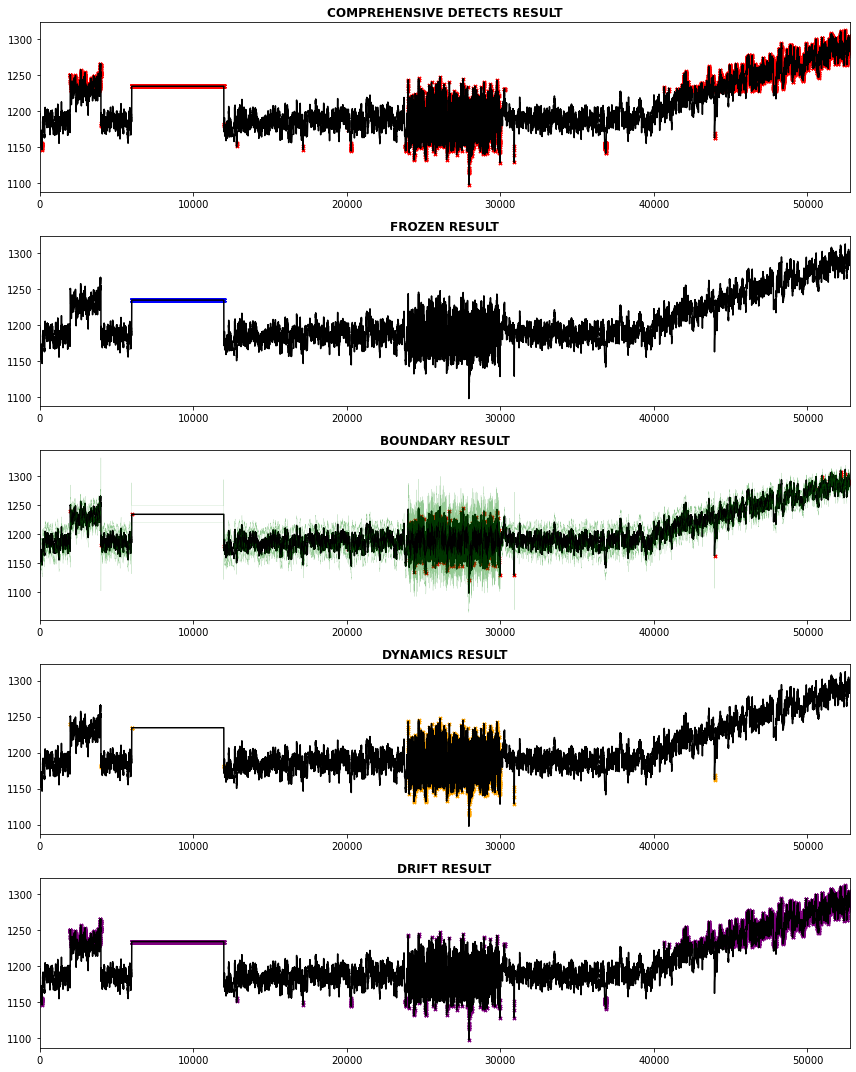

In [9]:
import matplotlib.pyplot as plt

# 테스트 데이터 리스트
test_data_list = list(test_data[test_tag_list].values[tracking_size:].flatten())

# 검출 결과를 담은 리스트
detecteds = [t if d else None for t, d in zip(test_data_list, detecteds)]
frz_chks = [t if d else None for t, d in zip(test_data_list, frz_res)]
bounds_chks = [t if d else None for t, d in zip(test_data_list, bounds_res)]
dyn_chks = [t if d else None for t, d in zip(test_data_list, dyn_res)]
drft_chks = [t if d else None for t, d in zip(test_data_list, drft_res)]

# 검출 결과 리스트를 하나로 묶음
chks = [detecteds, frz_chks, bounds_chks, dyn_chks, drft_chks]

# 그래프에 표시될 각 검출 결과의 이름
keys = ['Comprehensive Detects', 'frozen', 'boundary', 'dynamics', 'drift']

# 각 검출 결과의 색상
colors = ['red', 'blue', 'red', 'orange', 'purple']

# 그래프 생성
fig, axs = plt.subplots(len(chks), 1, figsize=(12, 3 * len(chks)))
for i, ax in enumerate(axs):
    # 현재 그래프에서 표시할 검출 결과 리스트
    chk = chks[i]
    
    # 검출 결과 이름
    key = keys[i].upper()
    
    # 검출 결과에 대한 색상
    color = colors[i]
    
    # 검출 결과 리스트를 검은색 실선으로 그리기
    ax.plot(test_data_list[:len(chk)], c='k')
    
    # 검출 결과 리스트를 산점도로 그리기
    ax.scatter(x=range(len(chk)), y=chk, s=10.5, c=color, marker='x')
    
    # x축 범위 설정
    ax.set_xlim(0, len(chk)-1)
    
    # 그래프 제목 설정 (검출 결과 이름, bold체로)
    ax.set_title(f"{key} RESULT", fontweight='bold')

    # Boundary 출력
    if i == 2:
        ax.plot(high_boundary, c='g', alpha=0.42 , linewidth=0.2)
        ax.plot(low_boundary, c='g', alpha=0.42, linewidth=0.2)

# 그래프 간격 설정 및 출력
plt.tight_layout()
plt.show();